<a href="https://colab.research.google.com/github/mairahazura/mairahazura/blob/main/Sports_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SPORTS IMAGE CLASSFICIATION USING CNN1 MODEL**

5 classes selection among 100 classes (originally):-
- basketball
- horse racing
- sumo wrestling
- swimming
- tennis

Current problem: overfitting model

# extra command:
!pip install tensorflow-gpu

In [ ]:
#Re-mount the dataset for activation:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Dec 30 13:44:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1.) IMPORT LIBRARY

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report

# 2.) LOAD DATA


In [ ]:
trainpath = '/content/drive/MyDrive/sportsdataset/train'
testpath = '/content/drive/MyDrive/sportsdataset/test'
valpath = '/content/drive/MyDrive/sportsdataset/valid' #prediction
csvpath = '/content/drive/MyDrive/sportsdataset/sports.csv' #metadata/mapping

In [ ]:


# Image and Batch Settings

IMAGE_SIZE = (228, 228) # Adjust if necessary, but (228, 228) is good for CNN1

BATCH_SIZE = 32

# 3.) PREP-PROCESSING DATA

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,       # Rotate images up to 30 degrees
    width_shift_range=0.2,   # Shift images horizontally up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically up to 20% of the height
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in missing pixels with nearest values
)


Convert the path images to dataset


In [ ]:


# Load the images and labels from the 'trainpath' directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    trainpath,                # The path to the training image directory
    seed=123,                 # Seed for shuffling the dataset (ensures reproducibility)
    image_size=IMAGE_SIZE,    # Resize all images to the specified IMAGE_SIZE (e.g., (256, 256))
    batch_size=BATCH_SIZE     # Number of images processed in each batch (e.g., 32 images per batch)
)


Found 729 files belonging to 5 classes.


In [ ]:
# Load the images and labels from the 'testpath' directory for testing the model
test_ds = tf.keras.utils.image_dataset_from_directory(
    testpath,                # The path to the testing image directory
    seed=123,                # Seed for shuffling the dataset (ensures reproducibility)
    image_size=IMAGE_SIZE,   # Resize all images to the specified IMAGE_SIZE (e.g., (256, 256))
    batch_size=BATCH_SIZE    # Number of images processed in each batch (e.g., 32 images per batch)
)

Found 25 files belonging to 5 classes.


In [ ]:
# Get the class names (labels) from the training dataset
classes_names = train_ds.class_names

# Print the list of class names (labels)
print(classes_names)


['basketball', 'horse racing', 'sumo wrestling', 'swimming', 'tennis']


In [ ]:
# Define a function to get all image file paths from a given directory
def getImagePaths(path):
    image_names = []  # Create an empty list to store the image paths

    # Walk through the directory and its subdirectories
    for dirname, _, filenames in os.walk(path):
        # Iterate through each file in the directory
        for filename in filenames:
            # Get the full path of each file by combining the directory and filename
            fullpath = os.path.join(dirname, filename)
            # Append the full path to the image_names list
            image_names.append(fullpath)
    # Return the list of all image file paths
    return image_names

# Get all image paths from the 'valpath' directory
images_paths = getImagePaths(valpath)

# Print the number of image paths found in the 'predpath' directory
print(len(images_paths))


25


In [ ]:
# Get all image file paths from the 'trainpath' directory
images_paths = getImagePaths(trainpath)

# Print the number of image paths found in the 'trainpath' directory
print(len(images_paths))


729


# 4.) DATA VISUALIZATION


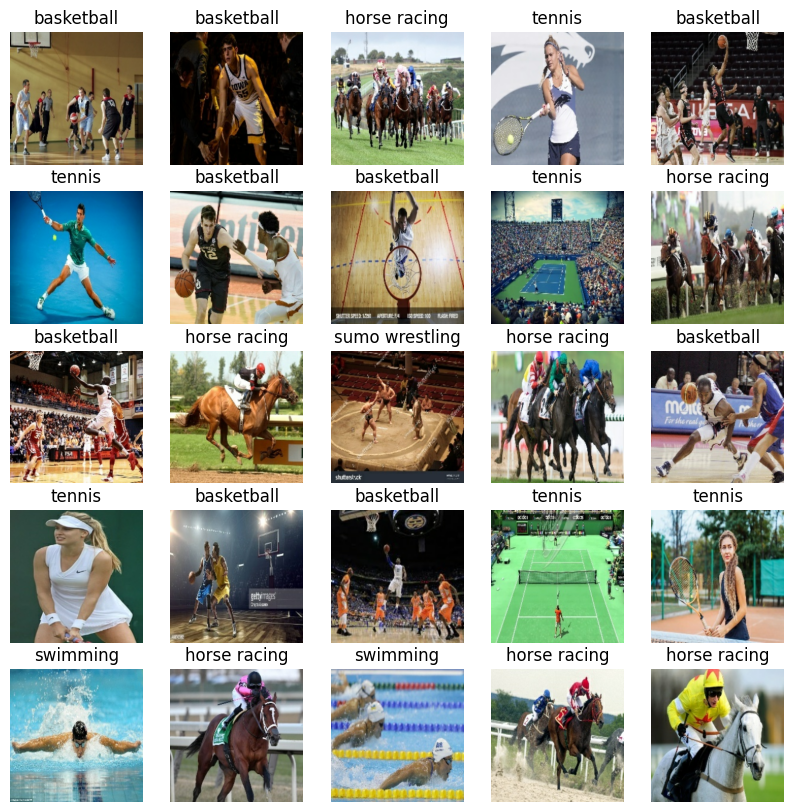

In [ ]:
# Create a new figure with a size of 10x10 inches
plt.figure(figsize=(10,10))

# Iterate through one batch of images and labels from the training dataset
for images, labels in train_ds.take(1):  # 'take(1)' retrieves one batch from the dataset
    for i in range(25):  # Loop to display the first 25 images in the batch
        ax = plt.subplot(5, 5, i + 1)  # Create a 5x5 grid of subplots

        # Display the i-th image in the batch
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert the image to a NumPy array and uint8 format

        # Set the title of the subplot to the corresponding class name
        plt.title(classes_names[labels[i]])

        # Turn off the axis lines for better visibility of the images
        plt.axis('off')


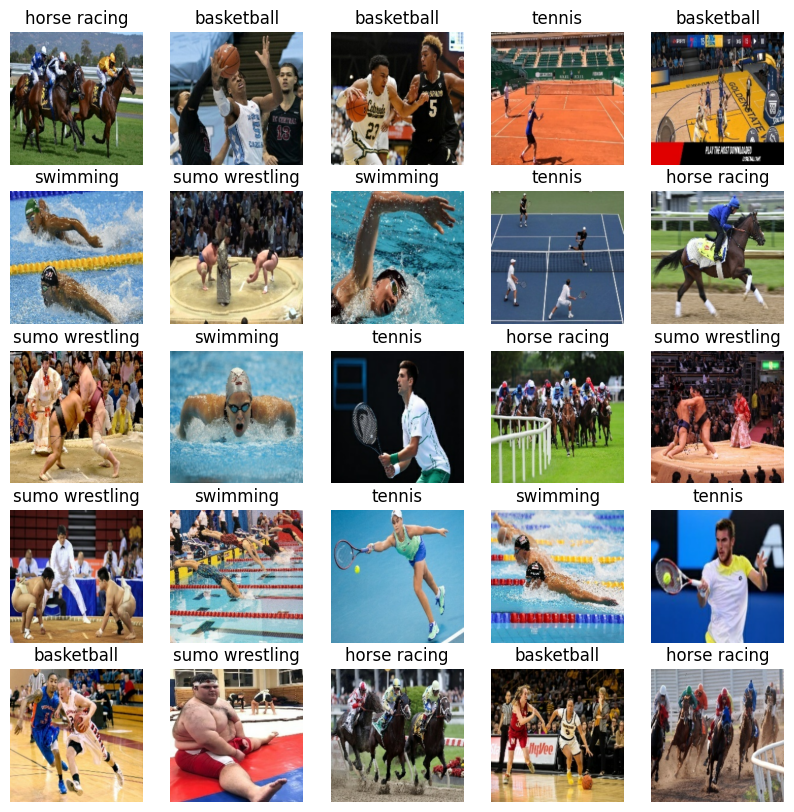

In [ ]:
#guna testpath
plt.figure(figsize=(10,10))
for image,labels in test_ds.take(1):
    for i in range(25):
        ax=plt.subplot(5,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(classes_names[labels[i]])
        plt.axis('off')

In [ ]:
# Initialize an empty dictionary to store the class names and their respective image counts
class_counts = {}

# Loop through each class directory inside the 'trainpath' directory
for class_name in os.listdir(trainpath):  # List all files and directories in 'trainpath'
    # Get the full path of the class directory
    class_dir = os.path.join(trainpath, class_name)

    # Check if the path corresponds to a directory (not a file)
    if os.path.isdir(class_dir):

        # Count the number of images (files) in the class directory
        num_images = len(os.listdir(class_dir))

        # Store the class name and its image count in the dictionary
        class_counts[class_name] = num_images

# Loop through the dictionary to print the class names and their respective image counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


sumo wrestling: 133 images
horse racing: 139 images
swimming: 157 images
tennis: 131 images
basketball: 169 images


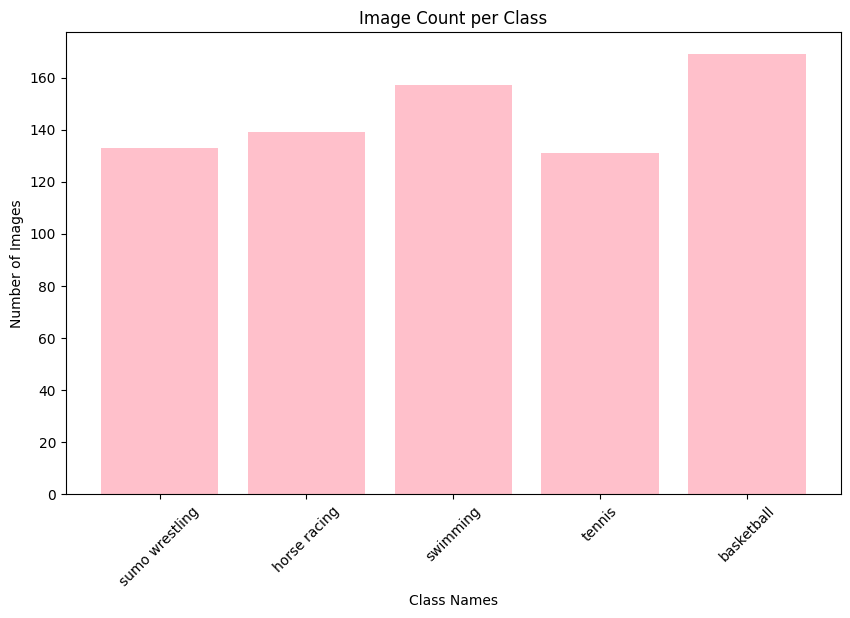

In [ ]:
#barcharts : 'train' dataset

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='pink')
plt.title('Image Count per Class')
plt.xlabel('Class Names')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#'TEST' DATASET

# Initialize an empty dictionary to store the class names and their respective image counts
class_counts = {}

# Loop through each class directory inside the 'testpath' directory
for class_name in os.listdir(testpath):  # List all files and directories in 'testpath'
    # Get the full path of the class directory
    class_dir = os.path.join(testpath, class_name)
    # Check if the path corresponds to a directory (not a file)
    if os.path.isdir(class_dir):
        # Count the number of images (files) in the class directory
        num_images = len(os.listdir(class_dir))
        # Store the class name and its image count in the dictionary
        class_counts[class_name] = num_images

# Loop through the dictionary to print the class names and their respective image counts
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


basketball: 5 images
horse racing: 5 images
tennis: 5 images
sumo wrestling: 5 images
swimming: 5 images


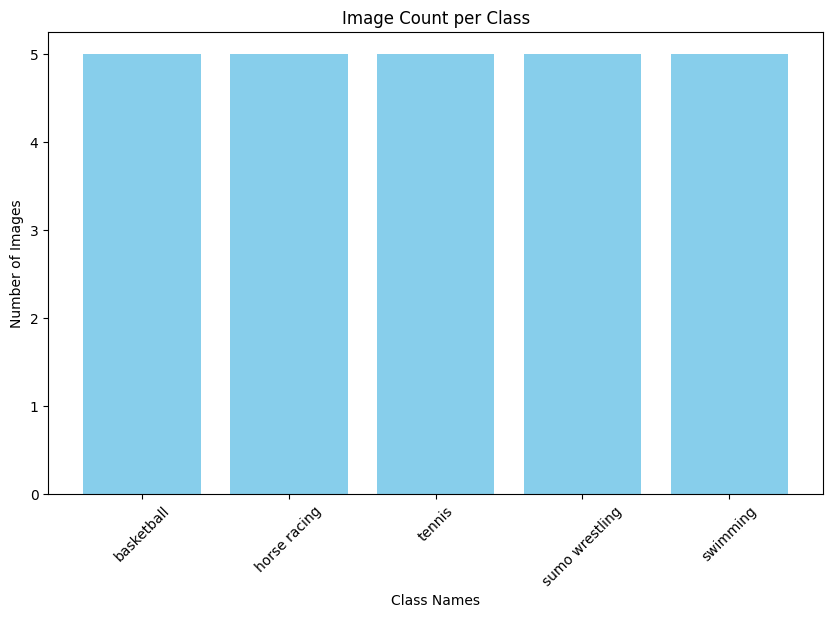

In [ ]:
##bar chart: utk 'test' dataset

# Create a new figure for the bar chart with a specific size (10x6 inches)
plt.figure(figsize=(10, 6))

# Create a bar chart using the class names as the x-axis and image counts as the y-axis
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')

# Set the title of the bar chart
plt.title('Image Count per Class')

# Label the x-axis
plt.xlabel('Class Names')

# Label the y-axis
plt.ylabel('Number of Images')

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Display the bar chart
plt.show()


Normalize Data process

In [ ]:
Norm_layer=tf.keras.layers.Rescaling(1/255)
train_ds=train_ds.map(lambda x , y :(Norm_layer(x),y))
test_ds=test_ds.map(lambda x , y :(Norm_layer(x),y))

# 5.) BUILD MODEL


In [ ]:
model=Sequential()
model.add(Input(shape=(228, 228, 3)))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(124,activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(units=len(classes_names),activation='softmax'))

In [ ]:
model.summary() #summary model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 108, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,639,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 124)                 │         127,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 124)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,859,885 (7.09 MB)

 Trainable params: 1,859,885 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model with necessary settings before training
model.compile(
    optimizer='adam',  # Adam is an optimization algorithm that adjusts the learning rate during training, making it efficient.

    # Sparse categorical crossentropy is used when the labels are integers (not one-hot encoded)
    loss='sparse_categorical_crossentropy',  # This function measures how well the model's predictions match the true labels.

    # 'accuracy' metric will be used to track how often the model's predictions are correct.
    metrics=['accuracy']  # This will allow us to monitor the model's performance during training.
)


In [ ]:
# EarlyStopping is used to stop training when the model's performance stops improving.
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # This tells the model to track the validation accuracy during training.

    # patience=5 means that training will stop if the model's validation accuracy doesn't improve
    # for 5 consecutive epochs (iterations over the entire dataset).
    patience=5,

    # restore_best_weights=True means that once training stops, the model will revert to the best weights
    # it had during training (where the validation accuracy was highest).
    restore_best_weights=True
)


In [ ]:
################obersavtion: if run code ni, boleh ubah train accuracy %. SO JGN RUN SESUKA HATI #########################

# Train the model using the training dataset and validate using the test dataset
history = model.fit(
    train_ds,  # The training dataset, where the model learns from.

    # The validation dataset, where the model's performance is tested after each epoch.
    validation_data=test_ds,

    epochs=50,  # The number of times the model will go through the entire training dataset.

    # List of callbacks (functions that get called during training) like early stopping.
    callbacks=[early_stopping]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - accuracy: 0.2360 - loss: 1.5699 - val_accuracy: 0.5200 - val_loss: 1.1782
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.5117 - loss: 1.1718 - val_accuracy: 0.4400 - val_loss: 0.9667
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5927 - loss: 0.9621 - val_accuracy: 0.5200 - val_loss: 0.9718
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6764 - loss: 0.7967 - val_accuracy: 0.4800 - val_loss: 0.9429
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6672 - loss: 0.8227 - val_accuracy: 0.5600 - val_loss: 1.0069
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7154 - loss: 0.6999 - val_accuracy: 0.5600 - val_loss: 1.1354
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.7178 - loss: 0.7027 - val_accuracy: 0.6400 - val_loss: 0.9487
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8077 - loss: 0.5110 - val_accuracy: 0.

In [ ]:
model.save("sports_model.h5")


# 6.) EVALUATE MODEL


In [ ]:
# Model accuracy for 'test' images
# highest accuracy test so far: 68.00% / 80.00%

loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8000 - loss: 1.0855
Test accuracy: 80.00%


In [ ]:
# Model accuracy for 'train' images
#highest train accuracy so far: 99.59%

loss, accuracy = model.evaluate(train_ds)
print(f'Train accuracy: {accuracy * 100:.2f}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9415 - loss: 0.1575
Train accuracy: 93.69%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Notes:
- Ideally, both training loss and validation loss should decrease over time, and they should remain **close to each other**. If the training loss keeps decreasing but the validation loss starts increasing, that could mean the model is overfitting.

- If the red line (Training Loss) keeps going down and the blue line (Validation Loss) starts going up after a certain point, your model might be overfitting.

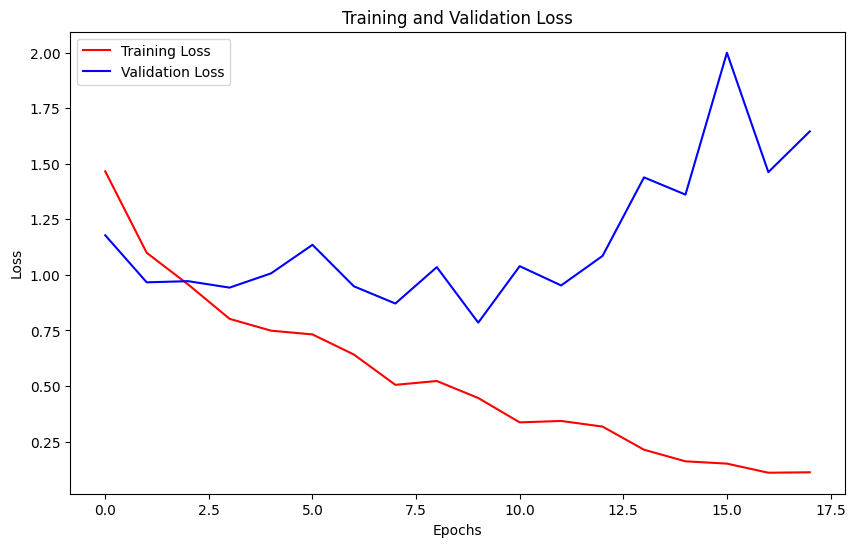

In [ ]:
#yg validation tu bukan 'valpath'

#Training Loss (loss): This is the model's error on the data it is learning from.
#Validation Loss (val_loss): This is the model's error on data it hasn't seen before (validation data).

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

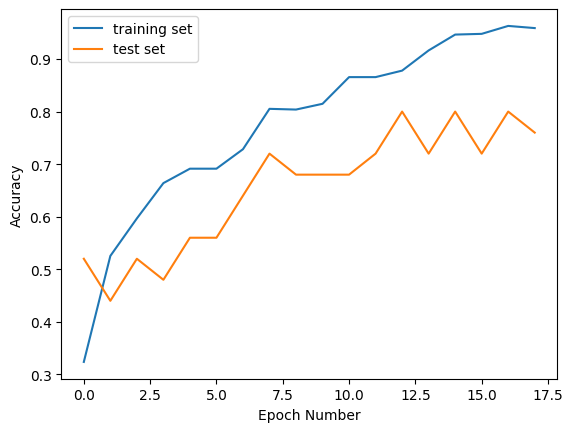

In [ ]:
#This plot helps visualize how well the model is performing on both the training data and the validation/test data over time (across epochs).

#Notes: If the training accuracy is much higher than the validation accuracy,
#your model may be overfitting (learning the training data too well but not generalizing to new data).

plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

# 7.) MAKE PREDICTION

In [ ]:
#Notes for error:  occurs because load_img is part of the keras.preprocessing.image module, not TensorFlow's core functionality. It seems like you're trying to call load_img on a TensorFlow object, which is causing the issue.
from tensorflow.keras.preprocessing import image


In [ ]:
def predict_img(file_name,model):
    img=image.load_img(file_name,target_size=(228,228))
    img_array=image.img_to_array(img)
    img_pro=np.expand_dims(img_array,axis=0)
    img_pro/=255
    img_pred=model.predict(img_pro)
    index = np.argmax(img_pred)

    plt.title("Prediction - {}".format(str(classes_names[index]).title()), size=18, color='red')
    plt.imshow(img_array)

In [ ]:
predict_img('/content/drive/MyDrive/sportsdataset/valid/basketball/1.jpg', model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step

In [ ]:
predict_img('/content/drive/MyDrive/sportsdataset/valid/horse racing/2.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


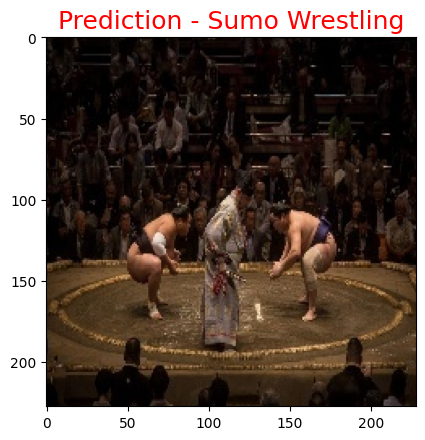

In [ ]:
predict_img('/content/drive/MyDrive/sportsdataset/valid/sumo wrestling/3.jpg', model)

# 8.) VISUALIZE SOME MISCLASSIFIED IMAGES

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
                precision    recall  f1-score   support

    basketball       0.57      0.80      0.67         5
  horse racing       1.00      1.00      1.00         5
sumo wrestling       0.75      0.60      0.67         5
      swimming       1.00      0.80      0.89         5
        tennis       0.80      0.80      0.80         5

      accuracy                           0.80        25
     macro avg       0.82      0.80      0.80        25
  weighted avg       0.82      0.80      0.80        25



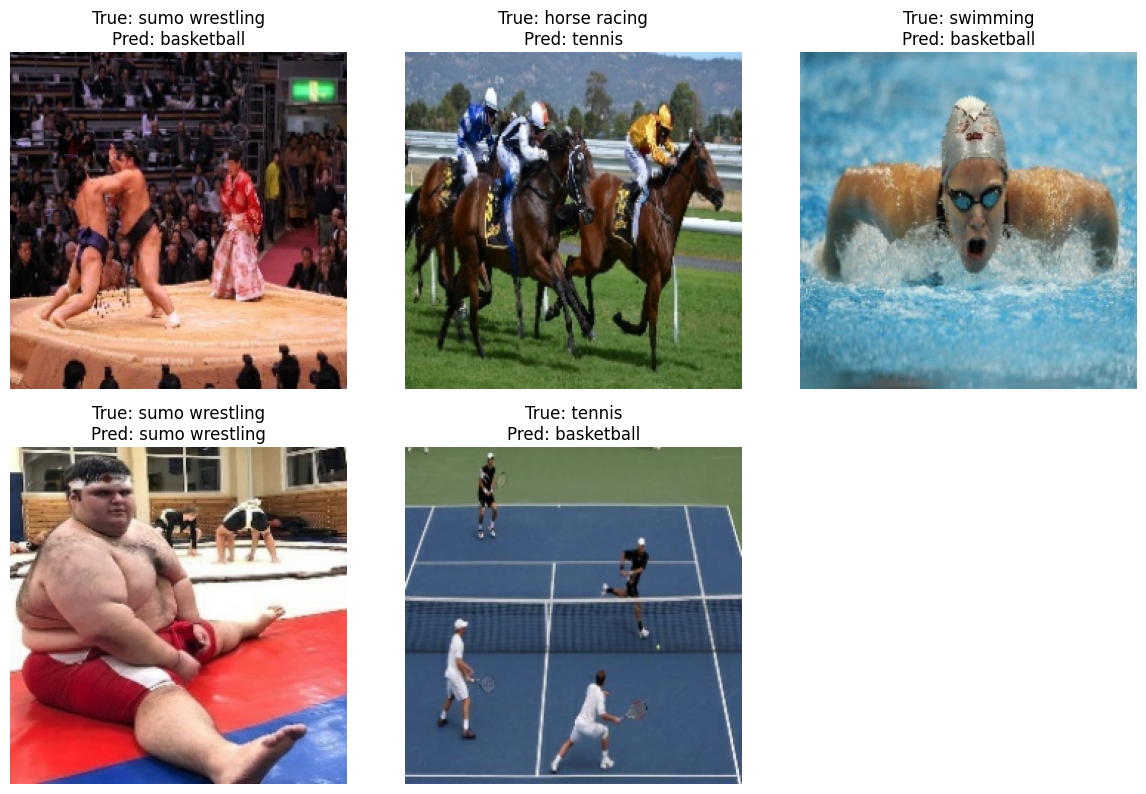

In [ ]:
#rerun the code to see prediction from other images as well

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=classes_names)
print(report)

misclassified_indices = np.where(y_true != y_pred)[0]

misclassified_images = []
misclassified_labels = []
misclassified_preds = []

for i, (images, labels) in enumerate(test_ds):
    if i * BATCH_SIZE >= len(y_true):
        break
    for j in range(len(images)):
        if len(misclassified_indices) == 0:
            break
        if (i * BATCH_SIZE + j) in misclassified_indices:
            misclassified_images.append(images[j].numpy())
            misclassified_labels.append(classes_names[labels[j]])
            misclassified_preds.append(classes_names[y_pred[i * BATCH_SIZE + j]])


plt.figure(figsize=(12, 12))
for i in range(min(9, len(misclassified_images))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((misclassified_images[i] * 255).astype("uint8"))
    plt.title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 9.) DEPLOYMENT

Deploy locally first


In [ ]:
!pip install streamlit
!pip install localtunnel
!pip install streamlit -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement localtunnel (from versions: none)
ERROR: No matching distribution found for localtunnel


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.124.173.175


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
⠙⠹⠸⠼⠴⠦Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) ^C
